# Exploration of my own Decision Tree Classifier and Sklearn Tree Module

The data set used in this project was created by webscraping Angie's List for potential new cold call leads for our company's product. The features include which category the business falls under (basements-and-foundations, kitchen-and-bath-remodeling, home-security-systems, landscaping, roofing, and home-exteriors), what decade the business was founded in, the number of reviews it has on Angie's List, and its average rating on the site.

The labels associated with each row (0, 1) indicate whether or not the business picked up the phone when our sales development reps called them. 

The goal of this project is to identify combinations of the features that most likely pick up the phone so we can prioritize that group when calling.

##### Table of Contents
    1. Clean and Explore Data Set
    2. Build, Train, and Test My Own Decision Tree Classifier
    3. Build, Train, and Test Decision Tree Classifier using Sklearn
    4. Comparing my Decision Tree Classifier to Sklean's

In [576]:
#general imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns

## Clean and Explore Data Set

In [577]:
# read in data set and drop rows with no reviews
df = pd.read_csv("newdata.csv", header = None)
df = df[df[3] != "Z"]
df = df[df[2] != 0]
df.columns = ["name", "category", "founded", "rating", "numreviews", "success"]
df.head()

,name,category,founded,rating,numreviews,success
0,A - 1 Plumbing Sewer & Drain Experts,basements-and-foundations,1980,D,0,0
1,"A DUIN-IT Roofing & Construction, Inc.",basements-and-foundations,1970,A,0,0
2,A J CRISS INDUSTRIES,basements-and-foundations,1960,A,0,1
3,A1 Premier Contractor Inc.,basements-and-foundations,2010,A,0,1
4,"Abolish, Design & Construction LLC",basements-and-foundations,1990,A,0,0


In [578]:
#group years by decades
df["founded"] = [int(np.floor(year / 10) * 10) for year in df["founded"]]
df["founded"] = [1950 if year <= 1950 else year for year in df["founded"]]

#group number of reviews by 10s
df["numreviews"] = [int(num) for num in df["numreviews"]]
df["numreviews"] = [int(np.floor(num / 10) * 10) for num in df["numreviews"]]
df["numreviews"] = [100 if num >100 else num for num in df["numreviews"]]
df["numreviews"] = [50 if num > 50 and num < 100 else num for num in df["numreviews"]]

print("Size of Dataset: " , df.shape)
df.head()

Size of Dataset:  (327, 6)


,name,category,founded,rating,numreviews,success
0,A - 1 Plumbing Sewer & Drain Experts,basements-and-foundations,1980,D,0,0
1,"A DUIN-IT Roofing & Construction, Inc.",basements-and-foundations,1970,A,0,0
2,A J CRISS INDUSTRIES,basements-and-foundations,1960,A,0,1
3,A1 Premier Contractor Inc.,basements-and-foundations,2010,A,0,1
4,"Abolish, Design & Construction LLC",basements-and-foundations,1990,A,0,0


## Build, Train, and Test My Own Decision Tree Classifier

In [579]:
'''
class: Node
'''
class Node:
    
    '''
    function: constructor
    
    inputs:
        question: dictionary that contains condition of node
        left: pointer to the left node on the tree
        right: pointer to the right node on the tree
    '''
    def __init__(self, question, left, right):
        self.question = question
        self.left = None
        self.right = None

In [580]:
'''
function: make_dictionaries(df)

inputs:
    df: total dataset
    
outputs:
    colValueDict: dictionary of unique values in each column
    colTypeDict: dictionary of type of each column
'''
def make_dictionaries(df):
    #initialize dictionaries
    colValueDict = {}
    colTypeDict = {}
    
    #find uique values in each column
    df = df.drop(["name"], axis = 1)
    for column in df:
        colValueDict[column] = df[column].unique()
    
    #delete label column
    del colValueDict["success"]
    
    #find types of each column
    for key, value in colValueDict.items():
        if key == "success":
            continue
        if isinstance(value[0], str):
            colTypeDict[key] = "categorical"
        else:
            colTypeDict[key] = "numerical"
            
    #return the two dictionaries
    return colValueDict, colTypeDict

In [581]:
'''
function: avg_gini_impurity(df, column_name, value, cat_num)

inputs:
    df: total dataset
    colunm_name: column that the split is happening on
    value: value in column that split is happening on
    cat_nam: type of the column (categorical or numerical)
    
outputs:
    outputs the average gini inpurity if that split is made
'''
def avg_gini_impurity(df, column_name, value, cat_num):
    #find splits in data frame based on type of column and given value
    if cat_num == "categorical":
        groupOfCategory = df.loc[df[column_name] == value]   
        groupNotOOfCategory = df.loc[df[column_name] != value]  
    else:
        groupOfCategory = df.loc[df[column_name] <= value]
        groupNotOfCategory = df.loc[df[column_name] > value]
        
    #find counts of labels in each group of split
    yes_df = groupOfCategory[groupOfCategory["success"] == 1]
    yes_count = yes_df.shape[0]
    
    no_df = groupOfCategory[groupOfCategory["success"] == 1]
    no_count = no_df.shape[0]
    
    total_count = groupOfCategory.shape[0]
    
    #return if df is empty
    if total_count == 0:
        return 0
    
    #calculate individual ginig impurities of each group of split
    impurity_yes = 1 - (yes_count / total_count)
    impurity_no = 1 - (no_count / total_count)
    
    #return average gini impurity
    return (yes_count / total_count) * impurity_yes + (no_count / total_count) * impurity_no

In [582]:
'''
function: find_best_split(df, colValueDict, colTypeDict)

inputs:
    df: total dataset
    colValueDict: dictionary of unique values in each column
    colTypeDict: dictionary of type of each column
    
outputs:
    bestCol: columns for the best split
    bestVal: value in column to split on
'''
def find_best_split(df, colValueDict, colTypeDict):
    #find current impurity
    success_df = df[df["success"] == 1]
    success_count = success_df.shape[0]
    total_count = df.shape[0]
    impurity = 1 - (success_count / total_count)
    
    #loop through each value in each column
    gain = 0
    bestCol = ""
    bestVal = 0
    for key, values in colValueDict.items():
        for val in values:
            if key == "success":
                continue
                
            #calculate gini imipurity
            avg_gini = avg_gini_impurity(df, key, val, colTypeDict[key])
            
            #replace bestCOl and bestVal if better imformation gain is foud
            if impurity - avg_gini >= gain:
                bestCol = key
                bestVal = val
    
    #return the bestCol and bestVal to split on
    return bestCol, bestVal

In [583]:
'''
function: build_tree(df, colValueDict, colTypeDict)

inputs:
    df: total dataset
    colValueDict: dictionary of unique values in each column
    colTypeDict: dictionary of type of each column
    
outputs:
    node: root of decision tree
'''
def build_tree(df, colValueDict, colTypeDict):
    #return none of all splits have been made or empty dataset
    if bool(colValueDict) == False:
        return None
    if df.shape[0] == 0:
        return None
    
    #find the best split and create node
    bestCol, bestVal = find_best_split(df, colValueDict, colTypeDict)
    
    question = {"col": bestCol, "value": bestVal}
    node = Node(question, None, None)
    
    #create groups based on best split vaues
    if colTypeDict[bestCol] == "categorical":
        groupOfCategory = df.loc[df[question["col"]] == question["value"]]   
        groupNotOfCategory = df.loc[df[question["col"]] == question["value"]]   
    else:
        groupOfCategory = df.loc[df[question["col"]] <= question["value"]]   
        groupNotOfCategory = df.loc[df[question["col"]] > question["value"]] 
        
    #remove value from dictionary
    colValueDict[bestCol] = np.delete(colValueDict[bestCol], np.where(colValueDict[bestCol] == bestVal))
    
    #remove column from dictionary if empty
    if colValueDict[bestCol].size == 0:
        del colValueDict[bestCol]
    
    #recurse to the left if condition is satisfied 
    node.left = build_tree(groupOfCategory, colValueDict, colTypeDict)
    
    #recurse to the right if condition is not satisfied
    node.right = build_tree(groupNotOfCategory, colValueDict, colTypeDict)
    
    #return node
    return node

In [584]:
'''
function:  get_value(row, root, colTypeDict, nameToIndex)

inputs:
    row: each row of test set
    root: node to split on
    colValueDict: dictionary of unique values in each column
    nameToIndex: mapping of name to index of columns
    
outputs:
    node: root of decision tree
'''
def get_value(row, root, colTypeDict, nameToIndex): 
    #get split condition
    question = root.question
    
    #determine type of column of split condition 
    if colTypeDict[question["col"]] == "categorical":
        
        #if left then either return none if no left node or recurse down left
        if row[nameToIndex[question["col"]]] == question["value"]:
            if root.left is not None:
                return get_value(row, root.left, colTypeDict, nameToIndex)
            else:
                return 0

        #if right then either return none if no right node or recurse down right
        if row[nameToIndex[question["col"]]] != question["value"]:
            if root.right is not None:
                return get_value(row, root.right, colTypeDict, nameToIndex)
            else:
                return 1
        
    elif colTypeDict[question["col"]] == "numerical":
        #if left then either return none if no left node or recurse down left
        if row[nameToIndex[question["col"]]] >= question["value"]:
            if root.left is not None:
                return get_value(row, root.left, colTypeDict, nameToIndex)
            else:
                return 0
            
        #if right then either return none if no right node or recurse down right
        if row[nameToIndex[question["col"]]] < question["value"]:
            if root.right is not None:
                return get_value(row, root.right, colTypeDict, nameToIndex)
            else:
                return 1
    
    return

In [585]:
'''
function:  predict(df, root, colTypeDict, nameToIndex)

inputs:
    row: each row of test set
    root: node to split on
    colValueDict: dictionary of unique values in each column
    nameToIndex: mapping of name to index of columns
    
outputs:
    prediction: lis of predictions for rows in the test set
'''
def predict(df, root, colTypeDict, nameToIndex):
    predictions = []
    for row in df.itertuples():
        predictions.append(get_value(row, root, colTypeDict, nameToIndex))
    return predictions

In [586]:
#train and test model

#train the model and build tree
train, test = train_test_split(df, test_size=0.2, shuffle=True)    
colValueDict, colTypeDict = make_dictionaries(df)
root = build_tree(df, colValueDict, colTypeDict)

#predict on test group with tree calssifier
nameToIndex = {"category": 2, "founded": 3, "rating": 4, "numreviews": 5}
labels = test['success'].to_list()
predictions = predict(test, root, colTypeDict, nameToIndex)

#calculate error rate of predictions
count_right = 0
for i in range(len(labels)):
    if labels[i] == predictions[i]:
        count_right = count_right + 1
print('\033[1m' +  "My Model Accuracy: ", count_right / len(labels))

My Model Accuracy:  0.6212121212121212


## Build, Train, and Test Decision Tree Classifier using Sklearn

In [587]:
#imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import tree

In [588]:
#No Need to split into train and test because we will use the same split as the one above
    #split data set into train and test sets
    #train, test = train_test_split(df, test_size=0.2, shuffle=True)

In [589]:
#split independent and dependent variables
inputs = train.drop(['success', 'name'], axis=1)
target = train["success"]

test_inputs = test.drop(['success', 'name'], axis=1)
test_labels = test["success"]

In [590]:
#label encode columns
le_category = LabelEncoder()
le_founded = LabelEncoder()
le_rating = LabelEncoder()
le_numreviews = LabelEncoder()

inputs["category_le"] = le_category.fit_transform(inputs["category"])
inputs["founded_le"] = le_founded.fit_transform(inputs["founded"])
inputs["rating_le"] = le_rating.fit_transform(inputs["rating"])
inputs["numreviews_le"] = le_numreviews.fit_transform(inputs["numreviews"])

test_inputs["category_le"] = le_category.fit_transform(test_inputs["category"])
test_inputs["founded_le"] = le_founded.fit_transform(test_inputs["founded"])
test_inputs["rating_le"] = le_rating.fit_transform(test_inputs["rating"])
test_inputs["numreviews_le"] = le_numreviews.fit_transform(test_inputs["numreviews"])

new_inputs = inputs.drop(["category", "founded", "rating", "numreviews"], axis = 1)
test_inputs = test_inputs.drop(["category", "founded", "rating", "numreviews"], axis = 1)

new_inputs.head()

,category_le,founded_le,rating_le,numreviews_le
72,3,5,0,0
102,3,6,0,0
303,1,6,0,0
222,5,3,0,0
155,4,5,0,0


In [591]:
#create classifier
model = tree.DecisionTreeClassifier()

#train classifier
model.fit(new_inputs, target)

#test classifier
print('\033[1m' + "Sklearn Model Accuracy: ", model.score(test_inputs, test_labels))

Sklearn Model Accuracy:  0.7424242424242424


## Comparing my Decision Tree Classifier to Sklean's
Both my classifier and the one created by the sklearn module have accuracies above 50%. I believe that since the "success" metric was based on whether or not the business picked up the phone when called as opposed to whether or not they signed up for a contract with our company, that there was an no correlation between the features in the sample set and the corresponding label. If we changed he metric to being based on whether or not the comany signs up for our product then we may see more correlations between which small business industry tends to gravitate towards our product. 

I think another thing that I should have done before I built a tree was to find the correlation coefficients of each feature/ column with the labels to see if the values in that column can help identify the label or if it is close to random.

In [597]:
inputs["label"] = target
inputs.head()

,category,founded,rating,numreviews,category_le,founded_le,rating_le,numreviews_le,label
72,kitchen-and-bath-remodeling,2000,A,0,3,5,0,0,1
102,kitchen-and-bath-remodeling,2010,A,0,3,6,0,0,1
303,home-exteriors,2010,A,0,1,6,0,0,1
222,roofing,1980,A,0,5,3,0,0,1
155,landscaping,2000,A,0,4,5,0,0,1


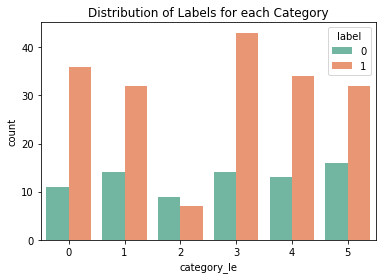

In [598]:
plt = sns.countplot(x = "category_le", hue = "label", data = inputs, palette = "Set2")\
.set_title('Distribution of Labels for each Category')

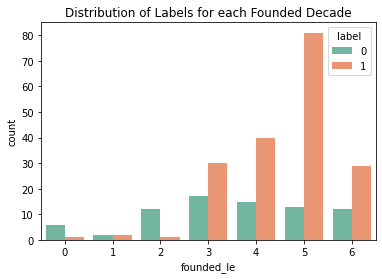

In [599]:
plt = sns.countplot(x = "founded_le", hue = "label", data = inputs, palette = "Set2")\
.set_title('Distribution of Labels for each Founded Decade')

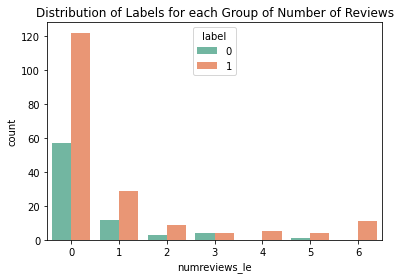

In [600]:
plt = sns.countplot(x = "numreviews_le", hue = "label", data = inputs, palette = "Set2")\
.set_title('Distribution of Labels for each Group of Number of Reviews')

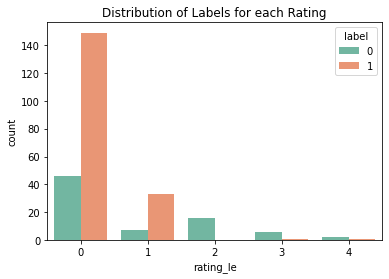

In [601]:
plt = sns.countplot(x = "rating_le", hue = "label", data = inputs, palette = "Set2")\
.set_title('Distribution of Labels for each Rating')

From the graph plotting founded decade versus success metric we can see that the companies founded in the late 1900 and 2000s have a much higher success metric than those founded before that. In fact the ones founded before tend not to pick up the phone, This trend is similar in the rating of the business. Higher rating tends to get more successes. 

The number of reviews and the category do not seem to have this relationship.

I think the next steps would be to build my tree using only the founded decade and rating and see if my accuracy goes up or down.